In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import warnings
import math
from colorama import Style, Fore
%matplotlib inline

warnings.filterwarnings('ignore')

rc = {
    "axes.facecolor": "#fff8e6",
    "figure.facecolor": "#fff8e6",
    "axes.edgecolor": "#000000",
    "grid.color": "#ebe7eb",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)


red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [4]:
## Load the dataset into the environment
training_data_url = "https://raw.githubusercontent.com/xdavidson/ai_hackathon/main/customer_support_tickets.csv"
df = pd.read_csv(training_data_url,storage_options={'verify': False})
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Sentiment
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN,Negative
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN,Negative
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3,Neutral
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3,Neutral
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1,Negative


In [5]:
## Data Processing
# Checking the shape of the dataset, rows, columns, duplicate entries & missing values

print(f'\033[94mNumber of records (rows) in the dataset are: {df.shape[0]}')
print(f'\033[94mNumber of features (columns) in the dataset are: {df.shape[1]}')
print(f'\033[94mNumber of duplicate entries in the dataset are: {df.duplicated().sum()}')
print(f'\033[94mNumber missing values in the dataset are: {sum(df.isna().sum())}')

Number of records (rows) in the dataset are: 8469
Number of features (columns) in the dataset are: 18
Number of duplicate entries in the dataset are: 0
Number missing values in the dataset are: 19916


In [6]:
df.dropna(subset=['Customer Satisfaction Rating'], inplace=True)

In [ ]:
# Removing duplicates
df.drop_duplicates(subset=['Ticket ID'], keep='first', inplace=True)


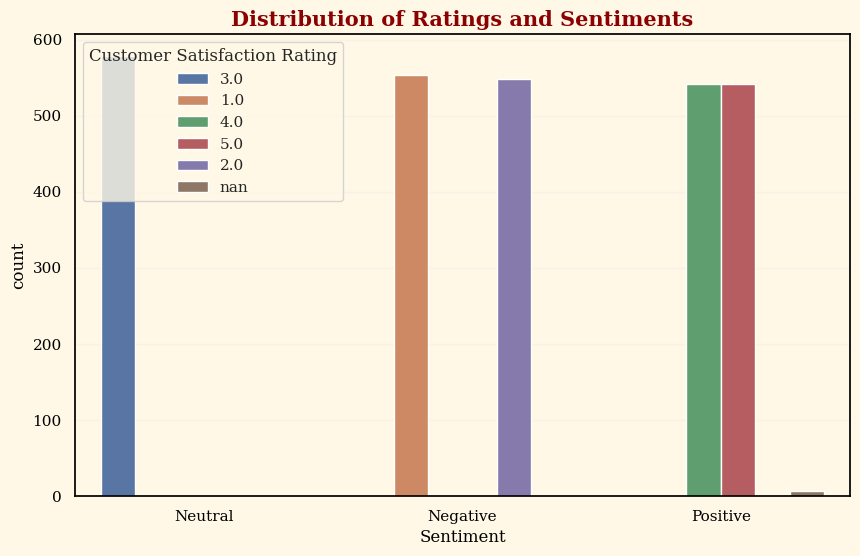

In [49]:
## Explratory Data Analysis
# A. Distribution of Ratings and Sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', hue='Customer Satisfaction Rating', data=df)
plt.title('Distribution of Ratings and Sentiments', fontsize = 15, fontweight = 'bold', color = 'darkred')
plt.savefig('Distribution of Ratings and Sentiments.png')
plt.show()

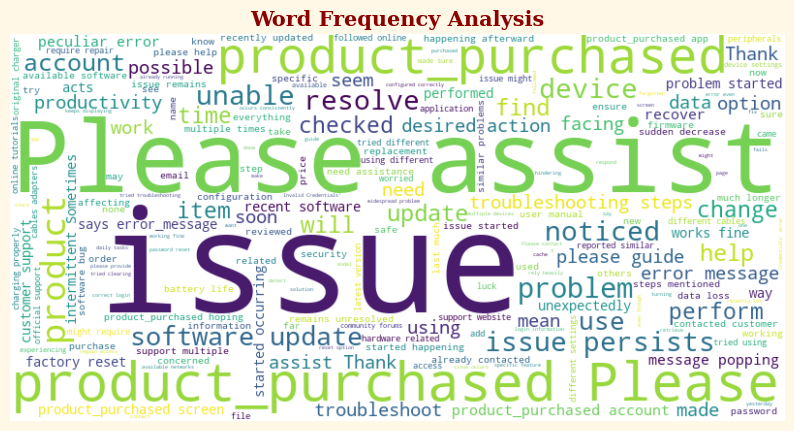

In [51]:
# B. Word Frequency Analysis
reviews = ' '.join(df['Ticket Description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency Analysis', fontsize = 15, fontweight = 'bold', color = 'darkred')
plt.savefig('Word Frequency Analysis.png')
plt.show()

In [9]:
## Sentiment Analysis
# 1. Using Customer Rating
# Convert 'Customer Satisfaction Rating' column to numeric
df['Customer Satisfaction Rating'] = pd.to_numeric(df['Customer Satisfaction Rating'], errors='coerce')

# Perform sentiment analysis
df['Sentiment (Using Rating)'] = df['Customer Satisfaction Rating'].apply(lambda x: 'Positive' if x >= 4 else 'Negative' if x <= 3 else 'Neutral')



In [12]:
# 2. Using Customer Review Text (Example: Using a simple sentiment analysis library like TextBlob)
from textblob import TextBlob
# Convert 'Customer Satisfaction Rating' column to strings
df['Customer Satisfaction Rating'] = df['Customer Satisfaction Rating'].astype(str)

# Perform sentiment analysis
df['Sentiment (Using TextBlob)'] = df['Customer Satisfaction Rating'].apply(lambda x: 'Positive' if TextBlob(x).sentiment.polarity > 0 else 'Negative')


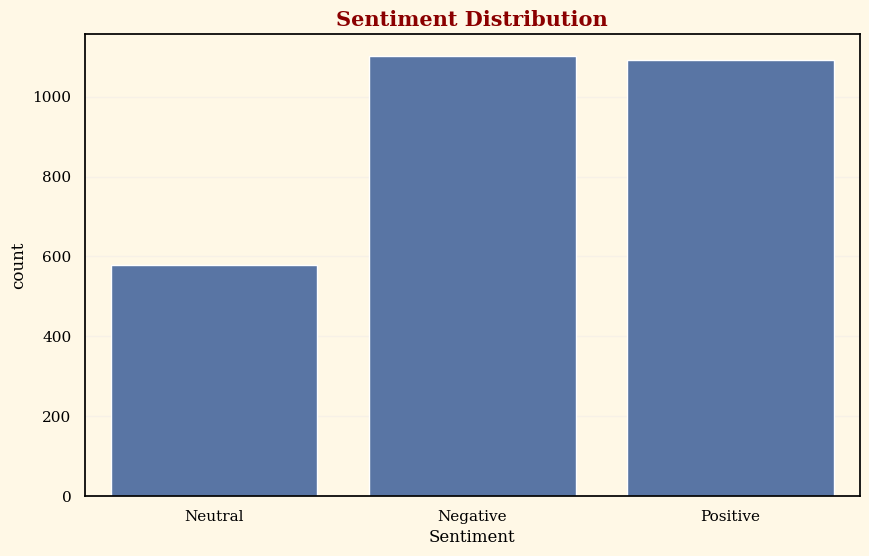

In [50]:
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution', fontsize = 15, fontweight = 'bold', color = 'darkred')
plt.savefig('Sentiment Distribution.png')
plt.show()

In [40]:
# C. Emotion Analysis Techniques (Rule-based approach using predefined emotion keywords)
happy_keywords = ['love', 'happy', 'joy', 'excited']
sad_keywords = ['sad', 'disappointed', 'unhappy', 'regret']
neutral_keywords = ['neutral', 'okay', 'fine']

def classify_emotion(text):
    if any(word in text for word in happy_keywords):
        return 'Happy'
    elif any(word in text for word in sad_keywords):
        return 'Sad'
    elif any(word in text for word in neutral_keywords):
        return 'Neutral'
    else:
        return 'Other'

df['Emotion (Rule-based)'] = df['Customer Satisfaction Rating'].apply(classify_emotion)

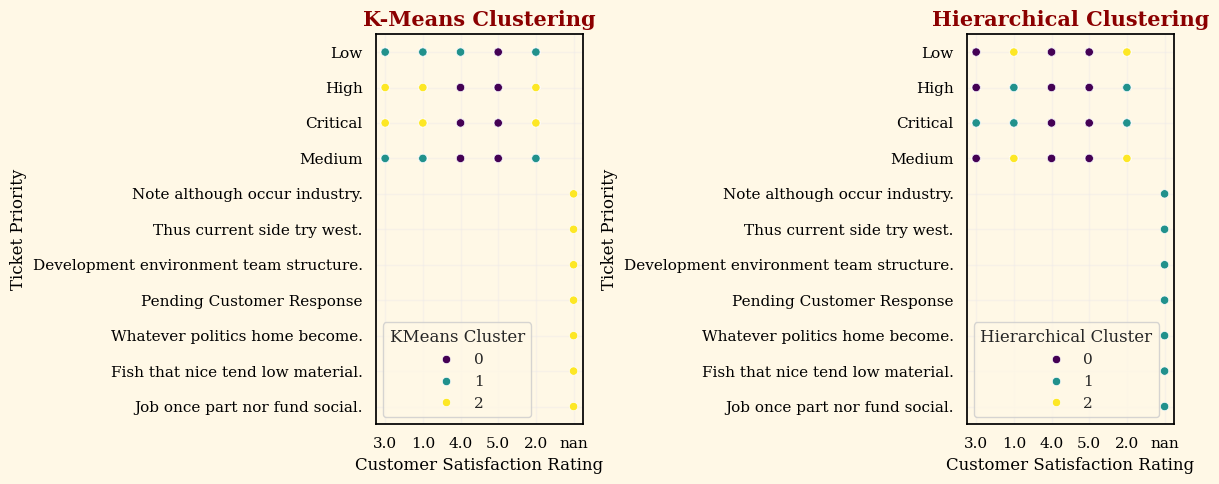

K-Means Cluster Counts:
1    954
0    935
2    881
Name: KMeans Cluster, dtype: int64

Hierarchical Cluster Counts:
0    1514
1     742
2     514
Name: Hierarchical Cluster, dtype: int64


In [52]:
import numpy as np

## Customer Segmentation using K-Means and Hierarchical Clustering
# Feature Selection for Clustering
X = df[['Customer Satisfaction Rating', 'Ticket Priority']]  # Select relevant features for clustering

# Convert 'Ticket Priority' column to string type
X['Ticket Priority'] = X['Ticket Priority'].astype(str)

# Assign numerical values to 'Ticket Priority' column
priority_mapping = {'Low': 4, 'Medium': 3, 'High': 2, 'Critical': 1}
X['Ticket Priority'] = X['Ticket Priority'].map(priority_mapping)

# Convert 'Customer Satisfaction Rating' column to numeric, ignoring errors
X['Customer Satisfaction Rating'] = pd.to_numeric(X['Customer Satisfaction Rating'], errors='coerce')

# Fill missing values in 'Customer Satisfaction Rating' with the mean of the column
X['Customer Satisfaction Rating'] = X['Customer Satisfaction Rating'].fillna(X['Customer Satisfaction Rating'].mean())

# Fill missing values in 'Ticket Priority' with a default value, for example, 0
X['Ticket Priority'] = X['Ticket Priority'].fillna(0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Customer Segmentation using K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
df['KMeans Cluster'] = kmeans.fit_predict(X_scaled)

# Customer Segmentation using Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
df['Hierarchical Cluster'] = hierarchical.fit_predict(X_scaled)

# Visualize the Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Customer Satisfaction Rating', y='Ticket Priority', hue='KMeans Cluster', data=df, palette='viridis')
plt.title('K-Means Clustering', fontsize=15, fontweight='bold', color='darkred')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Customer Satisfaction Rating', y='Ticket Priority', hue='Hierarchical Cluster', data=df, palette='viridis')
plt.title('Hierarchical Clustering', fontsize=15, fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('K-Means Clustering & Hierarchical Clustering.png')
plt.show()

# Print Results
kmeans_counts = df['KMeans Cluster'].value_counts()
hierarchical_counts = df['Hierarchical Cluster'].value_counts()

print("K-Means Cluster Counts:")
print(kmeans_counts)
print("\nHierarchical Cluster Counts:")
print(hierarchical_counts)


In [29]:
# Scale the features

scaler = StandardScaler()
X_kmeans =  scaler.fit_transform(X)
print(X_kmeans)

[[ 0.00721165  1.38769141]
 [ 0.00721165  1.38769141]
 [-1.41605896  1.38769141]
 ...
 [-1.41605896 -0.40100343]
 [ 0.00721165 -0.40100343]
 [ 0.00721165  0.49334399]]


In [31]:
# Model fitting with 5 clusters
clusters = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = clusters.fit_predict(X_kmeans)
y_kmeans


array([0, 0, 0, ..., 1, 3, 0], dtype=int32)

In [32]:
## Creating a New Dataframe with an appended cluster column

df_Kmeans = df.copy()            
df_Kmeans['Cluster'] = y_kmeans  
print(df_Kmeans.head(5))

    Ticket ID        Customer Name             Customer Email  Customer Age  \
2           3  Christopher Robbins  gonzalestracy@example.com            48   
3           4     Christina Dillon   bradleyolson@example.org            27   
4           5    Alexander Carroll    bradleymark@example.com            67   
10         11        Joseph Moreno         mbrown@example.org            48   
11         12       Brandon Arnold      davisjohn@example.net            51   

   Customer Gender          Product Purchased Date of Purchase  \
2            Other                   Dell XPS       2020-07-14   
3           Female           Microsoft Office       2020-11-13   
4           Female           Autodesk AutoCAD       2020-02-04   
10            Male            Nintendo Switch       2021-01-19   
11            Male  Microsoft Xbox Controller       2021-10-24   

             Ticket Type   Ticket Subject  \
2        Technical issue  Network problem   
3        Billing inquiry   Account acc

In [33]:
# Let's start the Hierarchial analysis by normalizing the data and
# building a dataframe for analysis
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()

X_Hierar = norm.fit_transform(X)
X_Hierar = pd.DataFrame(X_Hierar, columns=X.columns)
print(X_Hierar.head(5))

   Customer Satisfaction Rating  Ticket Priority
0                           0.5              1.0
1                           0.5              1.0
2                           0.0              1.0
3                           0.0              0.5
4                           0.0              0.5


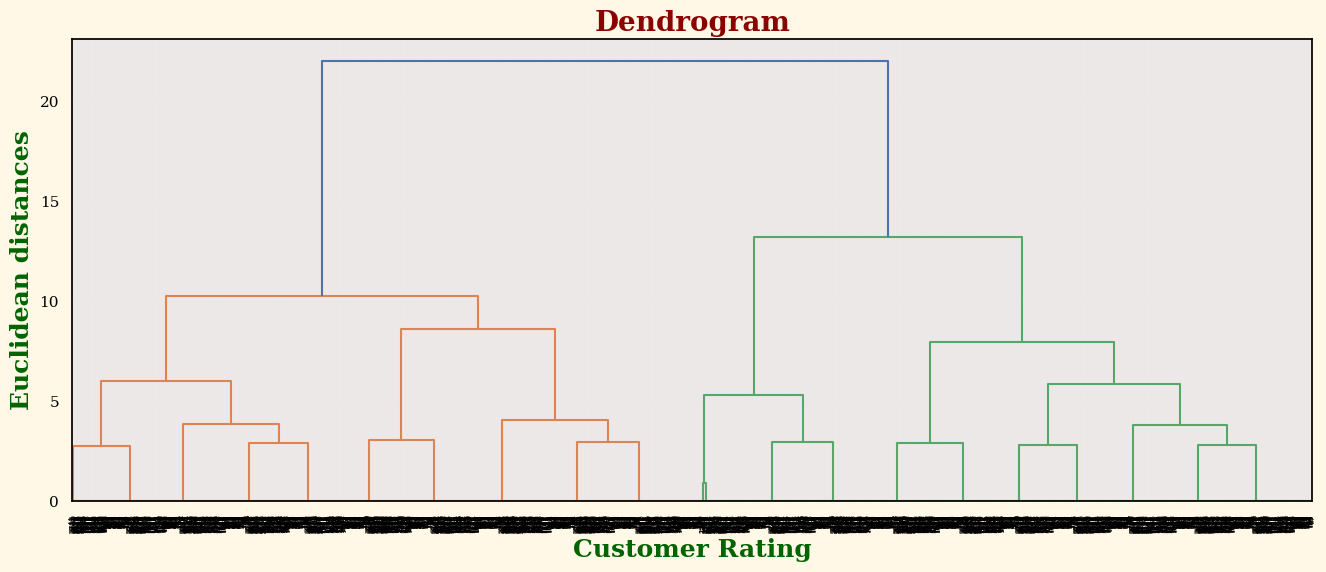

In [55]:
# Build dendrogram to find out the optimal number of clusters
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(16,6))
dendrogram = shc.dendrogram(shc.linkage(X_Hierar, method = 'ward'))
plt.title('Dendrogram', fontsize=20, fontweight = 'bold', color = 'darkred')
plt.xlabel('Customer Rating', fontsize=18, fontweight = 'bold', color = 'darkgreen')
plt.ylabel('Euclidean distances', fontsize=18,fontweight = 'bold', color = 'darkgreen')
plt.savefig('Dendrogram.png')
plt.show()

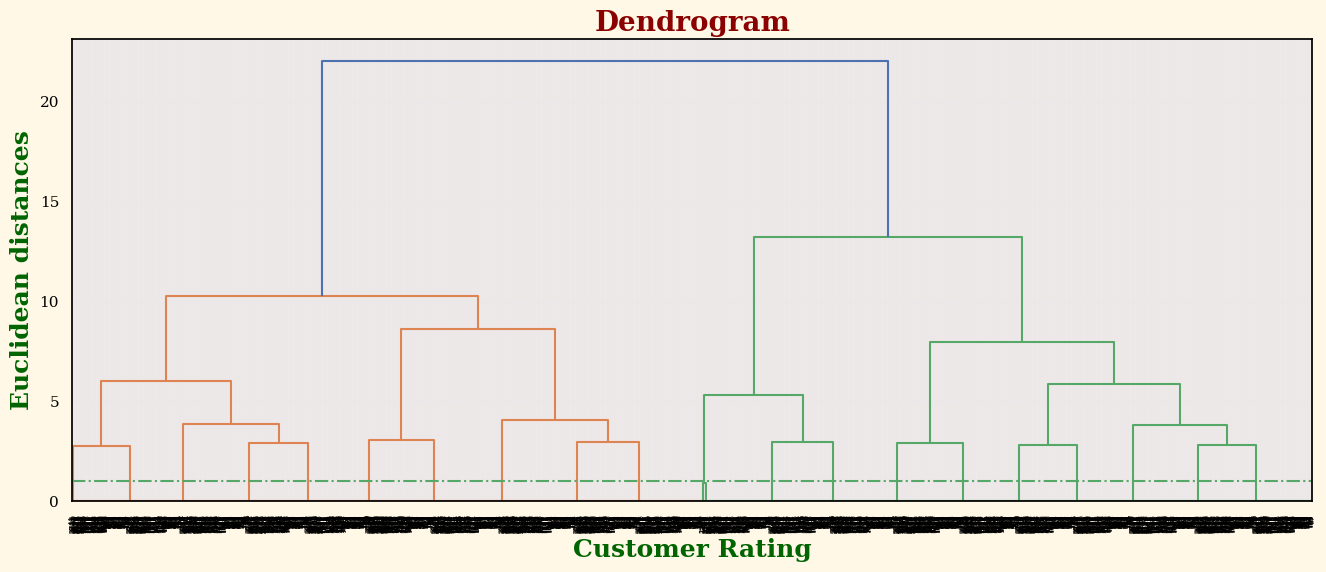

In [56]:
 #Draw the threshold level to identify the ideal number of clusters

plt.figure(figsize=(16,6))
dendrogram = shc.dendrogram(shc.linkage(X_Hierar, method = 'ward'))
plt.axhline(y = 1, color = 'g', linestyle = 'dashdot')

plt.title('Dendrogram', fontsize=20,fontweight = 'bold', color = 'darkred')
plt.xlabel('Customer Rating', fontsize=18,fontweight = 'bold', color = 'darkgreen')
plt.ylabel('Euclidean distances', fontsize=18,fontweight = 'bold', color = 'darkgreen')
plt.show()